<a href="https://colab.research.google.com/github/KhuramC/SoftwareTutorials/blob/main/B3_Rinput_FI_AP_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab B3 -Input Resistance, FI Curve, AP Propagation
This lab will go over many new related topics such as input resistance, the FI curve, AP(action potential) propagation through an axon, and myelin sheathing. Questions will be spread out throughout the notebook, but will also be repeated again at the end for the full list.

Install neuron for simulations.

In [1]:
!pip install neuron

In [2]:
!git clone https://github.com/davidfague/Neural-Modeling.git

fatal: destination path 'Neural-Modeling' already exists and is not an empty directory.


Compiling modfiles for cell simulation. Only needs to be done once.

In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

0


In [4]:
%cd Neural-Modeling/scripts/

/content/Neural-Modeling/scripts


In [5]:
import sys
sys.path.append("../")

In [6]:
from Modules.complex_cell import build_L5_cell_ziao


import numpy as np
import os

from neuron import h
h.load_file("stdrun.hoc")

1.0

In [7]:
import importlib
import constants

In [8]:
# Compile and load modfiles
ret_code = os.system(f"nrnivmodl {constants.modfiles_folder}")
if ret_code != 0:
    print(f"Failed to execute nrnivmodl. Return code: {ret_code}")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

NEURON: The user defined name already exists: ar
 near line 0
 ^
        nrn_load_dll("./x86_64/....")


RuntimeError: ignored

Creation of the cell that will be used.

In [9]:
cell = build_L5_cell_ziao(constants.complex_cell_folder) # build 4 compartment cell

NEURON: Gfluct2 is not a template
 in ziao_templates.hoc near line 503
 			noise = new Gfluct2(0.5)
                           ^
        xopen("ziao_templ...")
      execute1("{xopen("zi...")
    load_file("../complex...")


Geometry of the cell:

In [10]:
print("The diameter of the cell is " + str(round(cell.axon[0].diam,3)) + " microns")
print("The length of the cell is " + str(round(cell.axon[0].L,3)) + " microns")

The diameter of the cell is 14.097 microns
The length of the cell is 59.429 microns


## Input Resistance
Input resistance is a measure of how much membrane voltage will change with respect to current injection.

$$
R_{in} = \frac{ΔV}{I_{inject}}
$$
We will use a negative current injection and Ohm's Law to determine the cell's soma's input resistance.

# Current Clamp
The delay, duration and magnitude of the current are all defined here for the current injection.

In [11]:
# create current injection
IC = h.IClamp(cell.soma[0](0.5)) # create hoc current clamp object at the x=0.5 middle of soma
IC.delay = 100.0 # delay in ms
IC.dur = 1000.0 # duration in ms
IC.amp = -1.0 # amplitude in nA

# Simulation Parameters
Here we define how long the simulation is, starting voltage, record voltages within the soma and axon, record the leak current, and then run the simulation.

In [12]:
# define simulation parameters
h.tstop = tstop = 2000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = cell.soma[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = [] # list of leak current vectors
segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)



t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation


h.run() # run simulation

0.0

# Plotting Voltage
This graphs the voltage within the soma and axon throughout the simulation.



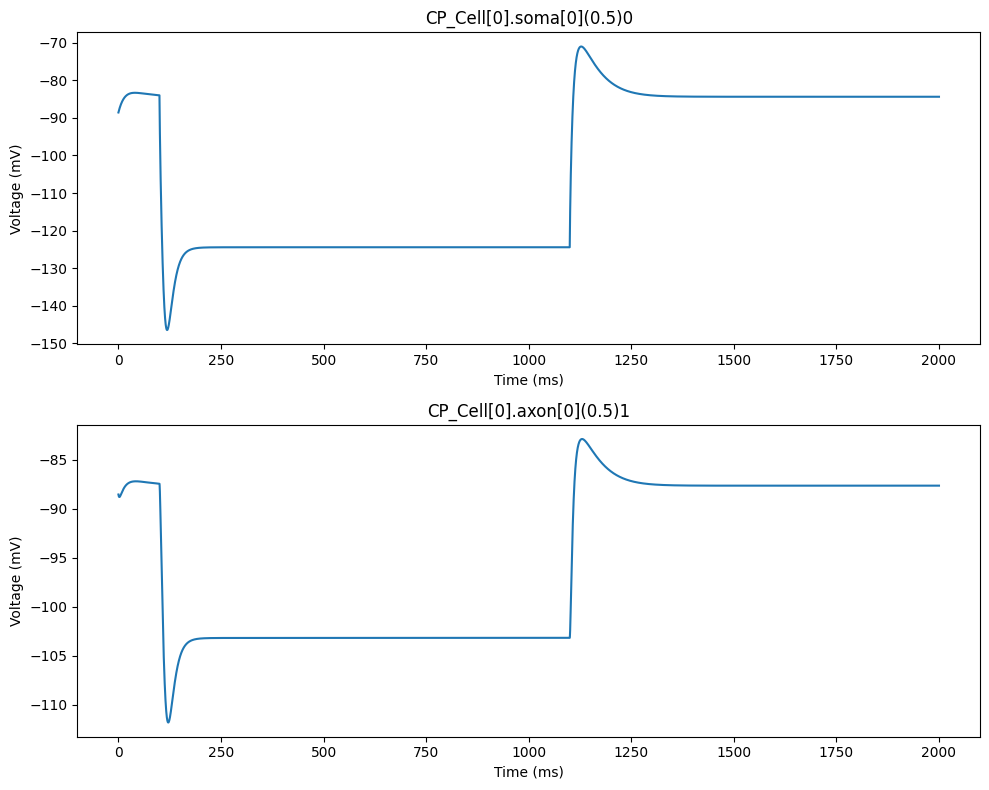

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 8))  # 10 subplots stacked vertically, figure size is 10x20 inches
for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg) + str(i))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Question
1. The overshoot in the voltage's response to negative current injection is indicative of a higher order system. What causes a multicompartmental model to be a higher order system?(Hint: think in terms of coupling first order differential equations to create higher order ones)

# Calculation of Input Resistance
$$
R_{in} = \frac{V_{rest}-V_{inject}}{I_{inject}}
$$
The input resistance is the change in voltage is just the difference from the resting membrane potential and steady state potential during injection. It is a passive property of the membrane. After finding it, we can just plug it in to find the input resistance.
(Note: voltage is measured in mV, which is 10^-3 V. Current is measured in nA, which is 10^-9 amps. After the division, you're left with 10 ^ 6 Ohms, which is 1 MOhm, which is why that is the unit used). For more information on input resistance, click [here.](https://www.scientifica.uk.com/learning-zone/passive-membrane-properties)

In [14]:
# Find Resting membrane potential
rest_time = (h.tstop + (IC.dur + IC.delay)) / 2 # guarantees to be at a time after current injection is over
# print(rest_time)
rest_time_index = int(rest_time / h.dt)
rest_V_soma = V_vecs[0][rest_time_index]
print(f"rest_V_soma: {rest_V_soma} mV")

# Find Steady state membrane potential during injection
inj_SS_time = (IC.dur + IC.delay) / 2
# print(inj_SS_time)
inj_SS_time_index = int(inj_SS_time / h.dt)
inj_SS_V_soma = V_vecs[0][inj_SS_time_index]
print(f"inj_SS_V_soma: {inj_SS_V_soma} mV")

# Compute input resistance
V_change = inj_SS_V_soma - rest_V_soma
print(f"V_change: {V_change} mV")
print(f"Current Injection Amplitude: {IC.amp} nA")
Input_resistance = V_change / IC.amp
print(f"Input_resistance: {Input_resistance} MOhms")


rest_V_soma: -84.34518830236995 mV
inj_SS_V_soma: -124.45032678181516 mV
V_change: -40.105138479445216 mV
Current Injection Amplitude: -1.0 nA
Input_resistance: 40.105138479445216 MOhms


# Questions
2.  What is Input Resistance?
3.  Is a cell with higher input resistance or lower input resistance more likely to fire an action potential when the same current is injected into the soma?
4.  Can the idea of Input Resistance be applied to dendritic compartments?

## F/I Curves

The F/I(Frequency-Current) curve shows the relationship beteween the frequency of spikes(or action potentials) to the amplitude of the current injected. It is sometimes call the FR-IC(Firing Rate-Current) curve as well.

# Simulation Parameters
The length of the simulation and inital voltages are the same as last time. This time we will be running multiple simulations with different levels of current injection(from -1 nA to 2 nA). While recording the voltage throughout these simulations, the amount of spikes created will also be recorded.

In [15]:
# # define simulation parameters
#h.tstop = tstop = 2000 # how long to run the simulation in ms
#h.dt = 0.025 # time step (resolution) of the simulation in ms
#h.v_init = cell.axon[0].e_pas # give v(0) = e_leak

# Perform Simulations with varying current injection amplitude

def set_spike_recorder(cell, spike_threshold, seg_to_record='soma') -> None:
    vec = h.Vector()
    if seg_to_record == 'soma':
      nc = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec = cell.soma[0])
    elif seg_to_record == 'axon':
      nc = h.NetCon(cell.axon[0](0.5)._ref_v, None, sec = cell.axon[0])
    else:
      raise(ValueError(f"{seg_to_record} should be 'soma' or 'axon'"))
    nc.threshold = spike_threshold
    nc.record(vec)
    return vec

V_vecs = [] # list of voltage vectors
segs = []
amps = np.arange(-1.0,2.,.25)
spike_arrays = []

for amp in amps:
  IC.amp = amp # amplitude in nA
  # record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
  i_leak_vecs = []


  spikes = set_spike_recorder(cell=cell, spike_threshold = 0)

  #record soma voltage
  seg = cell.soma[0](0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  #V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  seg_i_leak_vec.record(seg._ref_i_pas)
  i_leak_vecs.append(seg_i_leak_vec)

  t_vec = h.Vector() # time vector
  t_vec.record(h._ref_t) # record time during simulation
  h.run() # run simulation
  V_vecs.append(np.array(seg_V_vec))
  spike_arrays.append(spikes)

# Plotting Voltage
This graphs the voltage within the soma throughout current injection at the different amplitudes.

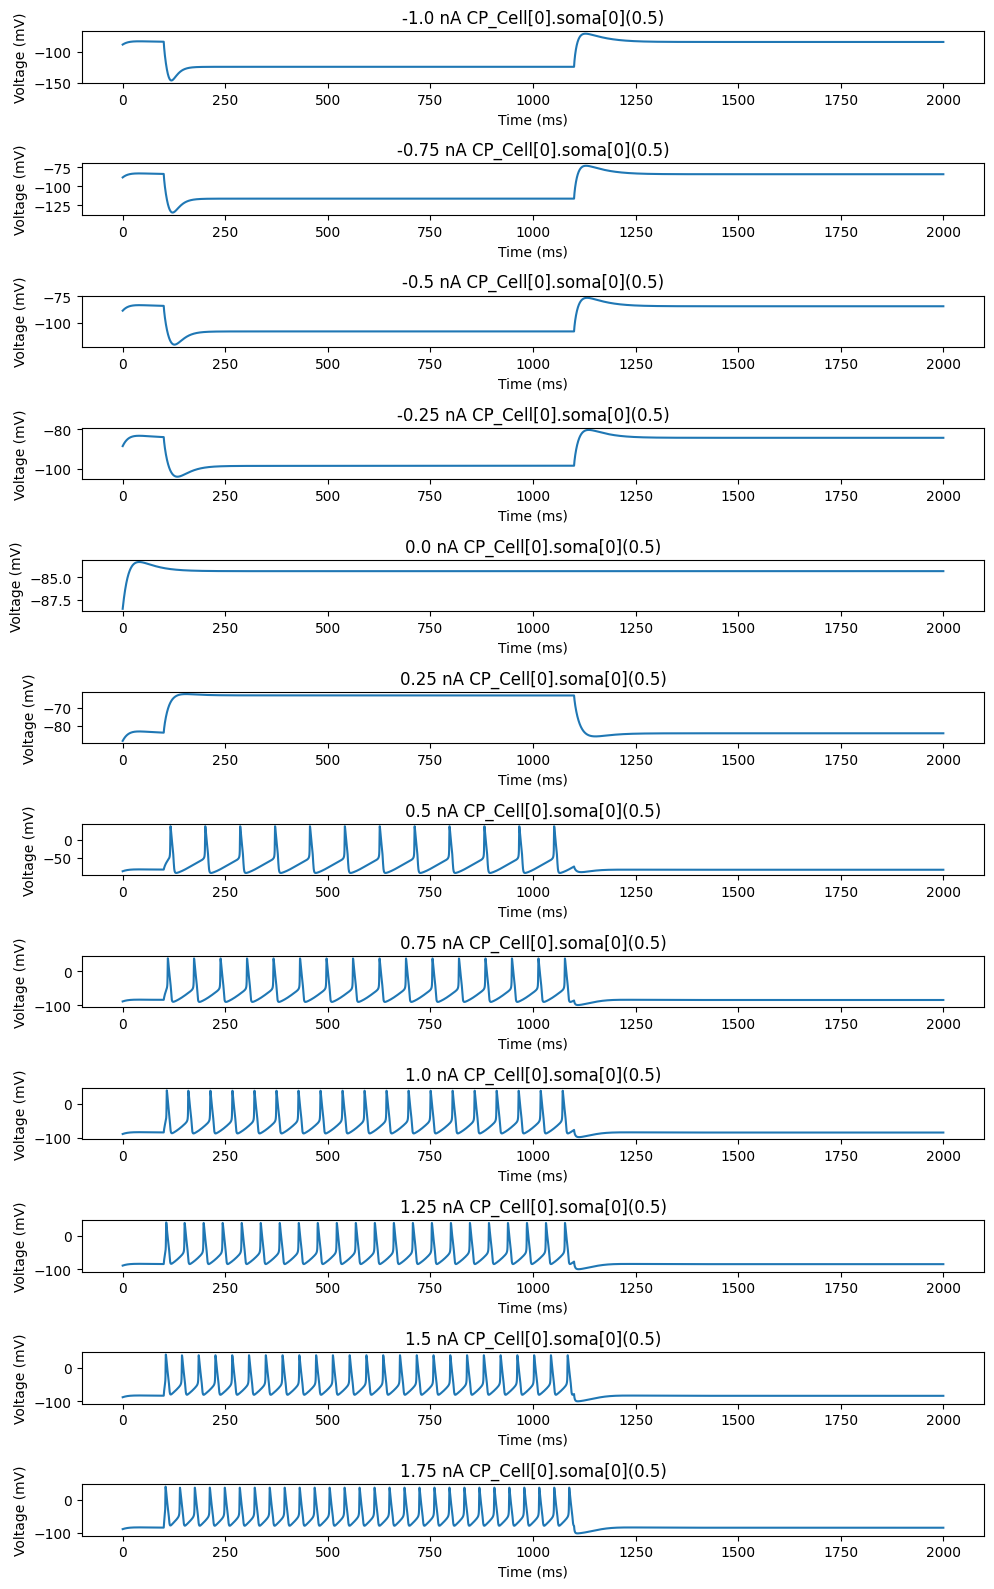

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x16 inches
for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(f"{amps[i]} nA {seg}")
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Firing Rates
Firing Rates are given in Hz(spikes per second). Firing rates are just the frequency in which a cell generates spikes. This will get the firing rates at each amplitude based off of how many spikes were generated during the simulation.

In [19]:
firing_rates = []
for spike_array in spike_arrays:
  #print(len(spike_array))
  num_spikes = len(spike_array)
  #print(len(spike_array))
  firing_rate = num_spikes / (IC.dur / 1000) #duration is in ms, so divide by /1000 to get in seconds
  firing_rates.append(firing_rate)

# Plotting the FI Curve
Now that we have the the frequency and current, we can plot it. Since the frequency is dependent on the current injected, the current will be on the x-axis and the frequency will be on the y-axis.

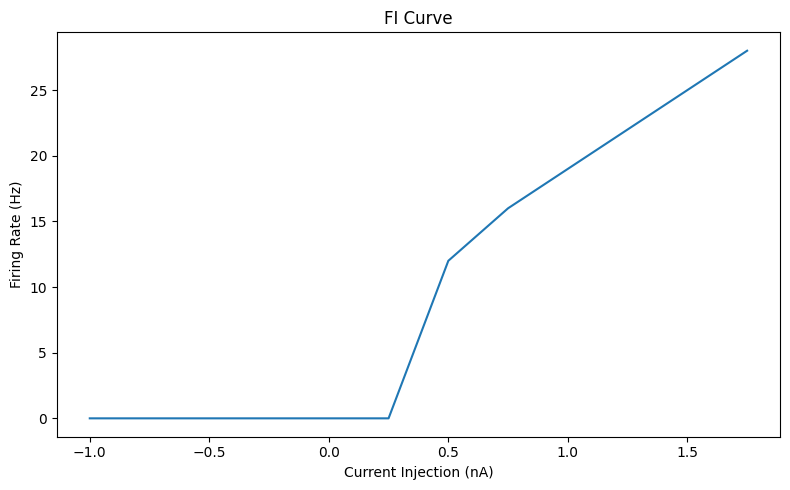

In [18]:
# Plot F/I curve
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # 10 subplots stacked vertically, figure size is 10x20 inches

axs.plot(amps, firing_rates)
axs.set_title(f"FI Curve")
axs.set_xlabel('Current Injection (nA)')
axs.set_ylabel('Firing Rate (Hz)')
  # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Question


5. Describe the slope of the FI curve using a piecewise function.

An example of a piecewise function:

$$
f(I) = \{I <= 0: \frac{dF}{dI} = 0, I > 0: \frac{dF}{dI} = 1 \}
$$

## Action Potential Propagation

Explore How Nodes of Ranvier and Myelin Sheath allow the Action Potential to reliable travel down the Axon.



1.   Elongate the Axon, adding long myelinated sections sepearted by Nodes of Ranvier. Myelinated sections should have a higher membrane resistance (lower leak conductance), and Nodes should have a higher density of active channels.
2.   Rerun the notebook with each Node of Ranvier's active conductances reduced to 10%. Explain the importance and role of the Nodes.
3.   Fix the previous adjustment. Rerun the notebook after increasing the Myelinated sections' leak conductance to 10 times greater. Explain the importance and role of the Myelin sheath.
4.   Fix the previous adjustment. Rerun the notebook after increasing the axial resistance to 10 times greater. What happens when the axial resistance is higher? Explain How axial resistance affect the propagation of an action potential.
5.   To make it easier for a voltage waveform to propagate along a dendrite, should the axial resistance be higher or lower? What about membrane resistance?

Nodes help differentiate spikes for longer the less conductance they have, otherwise they just transfer over the height of the spike's voltage.
Axial resistance needs to be low enough so that the action potential actually propagates, otherwise it will most likely just leak or something
Greater membrane resistance, so length constant is higher


Possibly make Ra / 10 in initial parameters because that's how it originally was.

In [ ]:
# Initial parameters
axon_diam = cell.axon[0].diam * 2 #2  # diameter of the axon
cell.axon[0].Ra = cell.axon[0].Ra / 10


# List to hold all axon sections
nodes = []
myelinated_sections = []
new_sections = []

# Define properties for myelinated segments and Nodes of Ranvier
myelin_length = 225 #1000
node_length = 1
# myelin_resistance = 1000
# node_resistance = 0.01

for i in range(10):
    if i % 2 == 0:  # Myelinated segment
        axon = h.Section(name='Myelinated[]'.format(i+1))
    else:
        axon = h.Section(name='Node[]'.format(i+1))
    new_sections.append(axon)
    axon.insert('hh')
    #  op0
    axon.cm = cell.axon[0].cm
    for seg in axon:
      seg.hh.el = cell.axon[0](0.5).pas.e
    axon.Ra = cell.axon[0].Ra #/ 3

    # connect to previous section
    if i == 0:
        axon.connect(cell.axon[0](1))
    else:
        axon.connect(new_sections[i-1](1))

    if i % 2 == 0:  # Myelinated segment
        myelinated_sections.append(axon)
        axon.L = myelin_length
        axon.diam = axon_diam
        axon.nseg = 20  # This might vary depending on your requirement
        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10000000  # Maximal conductance of K channels
            seg.hh.gkbar =0# 0.036/1000#0.036/10  # Maximal conductance of K channels
            seg.hh.gnabar = 0#0.12/1000  # Maximal conductance of Na channels
            #seg.hh.gl = seg.hh.gl / 100]===]==[==]


        # You might also add other properties specific to myelinated segments

    else:  # Node of Ranvier
        nodes.append(axon)
        axon.L = node_length
        axon.diam = axon_diam

        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10  # may update to 80 mS / unit area
            seg.hh.gkbar = 0.036 * 1000  # Maximal conductance of K channels
            seg.hh.gnabar = 0.12 * 500   # Maximal conductance of Na channels
            #seg.hh.gl = seg.hh.gl / 10
            #seg.hh.gkbar = seg.hh.gkbar / 10
            #seg.hh.gnabar = seg.hh.gnabar /10

        axon.nseg = 1  # Usually a node of ranvier is represented by one segment

    # Print out some properties for verification
    print("Axon section {}: L = {} um, diam = {} um".format(i, axon.L, axon.diam))


In [ ]:
def changeAllSections(change, param_to_change = 'diam') ->None:
  for section in new_sections:
    if(param_to_change == 'diam'):
      section.diam = (cell.axon[0].diam * 2) * change
    elif(param_to_change == 'Ra'):
        section.Ra = cell.axon[0].Ra * change
    else:
      raise(ValueError(f"{param_to_change}should be 'diam' or 'Ra'"))
      break



def changeNodeActiveConductance(change):
  for node in nodes:
    for seg in node:
        seg.hh.gkbar = seg.hh.gkbar * change
        seg.hh.gnabar = seg.hh.gnabar * change


def changeMyelinLeakConductance(change):
  for myelin in myelinated_sections:
    for seg in myelin:
      seg.hh.gl = (cell.axon[0](0.5).g_pas / 10000000) * change

def setMyelinConductance(value, channel_to_change = 'gl')->None:
  for myelin in myelinated_sections:
    for seg in myelin:
      if(channel_to_change == 'gl'):
        seg.hh.gl = value
      elif(channel_to_change == 'gkbar'):
        seg.hh.gkbar = value
      elif(channel_to_change == 'gnabar'):
        seg.hh.gnabar = value
      else:
        raise(ValueError(f"{channel_to_change}should be 'gl', 'gkbar', or 'gnabar'"))
        break
def changeToDefault():
  changeAllSections(1,'diam')
  changeAllSections(1,'Ra')
  changeNodeActiveConductance(1)
  changeMyelinLeakConductance(1)
  setMyelinConductance(0,'gkbar')
  setMyelinConductance(0,'gnabar')

def simulateNoMyelin():
  #changeMyelinLeakConductance(100000)
  setMyelinConductance(cell.axon[0](0.5).g_pas / 100, 'gl') # same gl as Node of Ranvier
  setMyelinConductance(0.036/1000,'gkbar') #same gk as Node of Ranvier
  setMyelinConductance(0.12/1000, 'gnabar') #same gna as Node of Ranvier

def set_node_spike_recorder(node, spike_threshold):

  vec = h.Vector()
  nc = h.NetCon(node(0.5)._ref_v,None,sec = node)
  nc.threshold = spike_threshold
  nc.record(vec)
  return vec




In [ ]:
IC.amp = 0.6
changeToDefault()
#changeNodeActiveConductance(1/10)
#changeMyelinLeakConductance(10)
#changeAllSections(10,'Ra')
simulateNoMyelin()


In [ ]:
# define simulation parameters
h.tstop = tstop = 2000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = cell.axon[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = []

segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

for axon in new_sections:
  seg = axon(0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  try:seg_i_leak_vec.record(seg._ref_i_pas)
  except:seg_i_leak_vec.record(seg._ref_il_hh)
  i_leak_vecs.append(seg_i_leak_vec)

first_node_spikes = set_node_spike_recorder(nodes[0],40)
last_node_spikes = set_node_spike_recorder(nodes[len(nodes)-1], 40)

t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

# vc_i_vec = h.Vector() # vector for recording voltage clamp current
# vc_i_vec.record(vc.i)

h.run() # run simulation

In [ ]:
# dir(new_sections[0](0.5).hh.il)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg) + str(i))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# AP(Action Potential) Propagation Speed
Here we will record when a spike occurs in the first node, then when its corresponding spike occurs within the last node. The difference in time is the speed.

In [ ]:
#print(first_node_spikes[0])
#print(last_node_spikes[0])
#print(first_node_spikes)
time = last_node_spikes[0] - first_node_spikes[0]
#print(time)

time_in_secs = time / 1000
length = 0
length = length +((len(myelinated_sections) - 1) * myelin_length)  # we subtract 1 since we are going from node to node, and that does not include the very first myelin sheath
length = length + (len(nodes) * node_length) #all in microns
length_in_meters = length / (10**6) #microns to meters
ap_velocity = length_in_meters / time_in_secs
print("AP velocity is " + str(round(ap_velocity,3)) +  " m/s")



make spike recorder at end node and first node and subtract the time values to get speed of ap time
To simulate without myelin sheath: do the same thing but make gl be divided by 10 instead, and put in the commented values for the the active channels
To confirm that input resistance is a constant, check for input resistance at a couple of other amps.(perhaps make a function to calculate it?)

add question:
why do we use negative current to measure input resistance?

TODO: add current injection for single somatic AP, and record Action Potential propagation time with and without myelin sheath. Need to figure out how to get model to behave similarly without myelin sheath.